Homework 2:<br>note: For starting the code please import sites.txt in "/content"




In [ ]:
!apt-get install tcpdump
!apt-get install tshark
!pip install --pre scapy[basic]
!pip install pyshark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpcap0.8
Suggested packages:
  apparmor
The following NEW packages will be installed:
  libpcap0.8 tcpdump
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 647 kB of archives.
After this operation, 1,773 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcap0.8 amd64 1.10.1-4build1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 tcpdump amd64 4.99.1-3ubuntu0.2 [501 kB]
Fetched 647 kB in 1s (1,070 kB/s)
Selecting previously unselected package libpcap0.8:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../libpcap0.8_1.10.1-4build1_amd64.deb ...
Unpacking libpcap0.8:amd64 (1.10.1-4build1) ...
Selecting previously unselected package tcpdump.
Preparing to unpack .../tcpdump_4.99.1-3ubunt

In [ ]:
import os
def packet_capturing(number_of_each_visits):
#this function will capture packets and store them as a csv file
  try:
    os.makedirs("captures")
  except:
    pass

  list_sites = open("sites.txt", "r").read().split(',')
  output_file = "https_capture.pcap"

  for i in range(len(list_sites)): #this iterate through the sites in sites.txt
    interface = list_sites[i]
    print (interface, type(interface))
    for j in range(number_of_each_visits): #visit each for number_of_each_visits times
      csv_file = f"/content/captures/https_captures_for_{list_sites[i].split('://')[1]}_{j+1}.csv"

      !timeout 10 tcpdump -i eth0 'tcp port 443' -nn -w $output_file  & (sleep 3; curl -s $interface > /dev/null)
      !tshark -r $output_file -T fields -e frame.number -e frame.time -e frame.len -e ip.len -e ip.proto -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -E header=y -E separator=, -E quote=d -E occurrence=f > $csv_file
      !rm $output_file


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [ ]:
packet_capturing(10)

In [ ]:
def ExtractFeatures(flow, df_flow):

  flow_features = {}
  flow_features['site_name'] = df_flow.iloc[0]['site_name']
  flow_features['direction'] = df_flow.iloc[0]['direction']

  flow_features['srcport']=flow[2]
  flow_features['dport']=flow[3]

  flow_features['number_of_packet'] = len(df_flow)

  packet_size = df_flow['ip.len'].astype(float)

  flow_features['total_of_bytes'] = packet_size.sum()
  flow_features['min_packet_size'] = packet_size.min()
  flow_features['max_packet_size'] = packet_size.max()
  flow_features['mean_packet_size'] = packet_size.mean()
  flow_features['std_packet_size'] = packet_size.std()

  df_flow['frame.time'] = pd.to_datetime(df_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
  iat = df_flow['frame.time'].diff(1).dt.total_seconds().iloc[1:]

  flow_features['duration'] = iat.sum()
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()

  return flow_features

In [ ]:
def direction_ditector(ip_src):
  #this will ditect the direction of our data
  if ip_src.split('.')[0] == '172':
    return 'uplink'
  else:
    return 'downlink'

In [ ]:
def data_frame_maker():
  #this func first of all add all the csv files to a singular data frame that we called it as new_df
  #then filter them out by ip.proto=6, after that we group them and extract the features and put them in dataset
  paths = "/content/captures"
  tcpdumpfiles = []
  for path in listdir(paths):
    path = join(paths, path)
    if isfile(path):
      tcpdumpfiles.append(path)

  new_df = pd.DataFrame()


  for path in tcpdumpfiles:
    try:
      df = pd.read_csv(path,low_memory=False)
      df['site_name'] = path.split('.')[1]
      new_df = new_df.append(df)
    except:
      pass

  df_tcp = new_df[new_df["ip.proto"]==6]
  df_tcp['direction'] = df_tcp['ip.src'].apply(direction_ditector)
  df_flow_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  dataset_list = []
  for flow,df_flow in df_flow_tcp:
    flow_features = ExtractFeatures(flow,df_flow)
    dataset_list.append(pd.DataFrame([flow_features]))
  dataset = pd.DataFrame()
  dataset = pd.concat(dataset_list, ignore_index=True)
  display(dataset)
  return dataset

In [ ]:
dataset = data_frame_maker()

<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-i

,site_name,direction,srcport,dport,number_of_packet,total_of_bytes,min_packet_size,max_packet_size,mean_packet_size,std_packet_size,duration,min_iat,max_iat,mean_iat,std_iat
0,express,uplink,34560,443,58,3842.0,40.0,569.0,66.241379,68.978082,0.623706,0.000012,0.285474,0.010942,0.041001
1,express,uplink,34812,443,57,3802.0,52.0,569.0,66.701754,69.501276,0.245243,0.000011,0.054977,0.004379,0.010191
2,express,uplink,50530,443,55,3698.0,52.0,569.0,67.236364,70.718001,0.146796,0.000011,0.055037,0.002718,0.007791
3,express,uplink,37612,443,56,3750.0,52.0,569.0,66.964286,70.101735,0.150624,0.000012,0.054593,0.002739,0.007650
4,express,uplink,32810,443,55,3698.0,52.0,569.0,67.236364,70.718001,0.141687,0.000007,0.055078,0.002624,0.007733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,rt,downlink,443,50784,150,396795.0,52.0,2828.0,2645.300000,671.173856,1.038398,0.000002,0.181732,0.006969,0.021425
196,abc,downlink,443,33396,65,232072.0,52.0,5844.0,3570.338462,2094.459830,0.228493,0.000001,0.070779,0.003570,0.010065
197,abc,downlink,443,51124,68,232228.0,52.0,5844.0,3415.117647,2048.943641,0.239300,0.000001,0.070199,0.003572,0.009842
198,abc,downlink,443,57250,77,232709.0,52.0,4396.0,3022.194805,1614.289269,0.406137,0.000001,0.072626,0.005344,0.013080


In [ ]:
def final_df_maker (df):
  #it will find the same dport and srcport and put them in a single row
  df_up = df[df['direction'] == 'uplink']
  df_down = df[df['direction'] == 'downlink']
  final_list = []

  for index_up, up in df_up.iterrows():
    for index_down, down in df_down.iterrows():
      if (up.srcport == down.dport) and (up.site_name == down.site_name):
        temp_dict = {}
        temp_dict['site_name'] = down.site_name

        temp_dict['number_of_packet_up'] = up.number_of_packet
        temp_dict['total_of_bytes_up'] = up.total_of_bytes
        temp_dict['min_packet_size_up'] = up.min_packet_size
        temp_dict['max_packet_size_up'] = up.max_packet_size
        temp_dict['mean_packet_size_up'] = up.mean_packet_size
        temp_dict['std_packet_size_up'] = up.std_packet_size
        temp_dict['duration_up'] = up.duration
        temp_dict['min_iat_up'] = up.min_iat
        temp_dict['max_iat_up'] = up.max_iat
        temp_dict['mean_iat_up'] = up.mean_iat
        temp_dict['std_iat_up'] = up.std_iat


        temp_dict['number_of_packet_down'] = down.number_of_packet
        temp_dict['total_of_bytes_down'] = down.total_of_bytes
        temp_dict['min_packet_size_down'] = down.min_packet_size
        temp_dict['max_packet_size_down'] = down.max_packet_size
        temp_dict['mean_packet_size_down'] = down.mean_packet_size
        temp_dict['std_packet_size_down'] = down.std_packet_size
        temp_dict['duration_down'] = down.duration
        temp_dict['min_iat_down'] = down.min_iat
        temp_dict['max_iat_down'] = down.max_iat
        temp_dict['mean_iat_down'] = down.mean_iat
        temp_dict['std_iat_down'] = down.std_iat
        final_list.append(temp_dict)

  #print(final_list)
  return final_list


In [ ]:
final_df = final_df_maker(dataset)
final_df = pd.DataFrame(final_df)
display(final_df)

,site_name,number_of_packet_up,total_of_bytes_up,min_packet_size_up,max_packet_size_up,mean_packet_size_up,std_packet_size_up,duration_up,min_iat_up,max_iat_up,...,total_of_bytes_down,min_packet_size_down,max_packet_size_down,mean_packet_size_down,std_packet_size_down,duration_down,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,express,58,3842.0,40.0,569.0,66.241379,68.978082,0.623706,0.000012,0.285474,...,448499.0,52.0,24328.0,8305.537037,6891.672809,0.612495,0.000001,0.274787,0.011557,0.042278
1,express,57,3802.0,52.0,569.0,66.701754,69.501276,0.245243,0.000011,0.054977,...,448189.0,52.0,21472.0,8299.796296,7117.682569,0.235141,0.000001,0.065393,0.004437,0.011965
2,express,55,3698.0,52.0,569.0,67.236364,70.718001,0.146796,0.000011,0.055037,...,447876.0,52.0,24683.0,8781.882353,6733.702615,0.136431,0.000001,0.065064,0.002729,0.009348
3,express,56,3750.0,52.0,569.0,66.964286,70.101735,0.150624,0.000012,0.054593,...,447878.0,52.0,21472.0,8957.560000,6007.866225,0.140301,0.000002,0.064668,0.002863,0.009373
4,express,55,3698.0,52.0,569.0,67.236364,70.718001,0.141687,0.000007,0.055078,...,447948.0,52.0,24328.0,8783.294118,6535.702314,0.131904,0.000001,0.065253,0.002638,0.009306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,rt,155,8857.0,40.0,569.0,57.141935,42.529049,1.165748,0.000007,0.130571,...,396795.0,52.0,2828.0,2645.300000,671.173856,1.038398,0.000002,0.181732,0.006969,0.021425
96,abc,67,4300.0,40.0,569.0,64.179104,64.593115,0.245435,0.000004,0.054467,...,232072.0,52.0,5844.0,3570.338462,2094.459830,0.228493,0.000001,0.070779,0.003570,0.010065
97,abc,68,4364.0,40.0,569.0,64.176471,64.075734,0.254498,0.000002,0.055685,...,232228.0,52.0,5844.0,3415.117647,2048.943641,0.239300,0.000001,0.070199,0.003572,0.009842
98,abc,75,4790.0,40.0,569.0,63.866667,61.341607,0.421951,0.000004,0.057431,...,232709.0,52.0,4396.0,3022.194805,1614.289269,0.406137,0.000001,0.072626,0.005344,0.013080


**KNN Part**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
final_df.head(5)

,site_name,number_of_packet_up,total_of_bytes_up,min_packet_size_up,max_packet_size_up,mean_packet_size_up,std_packet_size_up,duration_up,min_iat_up,max_iat_up,...,total_of_bytes_down,min_packet_size_down,max_packet_size_down,mean_packet_size_down,std_packet_size_down,duration_down,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,express,58,3842.0,40.0,569.0,66.241379,68.978082,0.623706,0.000012,0.285474,...,448499.0,52.0,24328.0,8305.537037,6891.672809,0.612495,0.000001,0.274787,0.011557,0.042278
1,express,57,3802.0,52.0,569.0,66.701754,69.501276,0.245243,0.000011,0.054977,...,448189.0,52.0,21472.0,8299.796296,7117.682569,0.235141,0.000001,0.065393,0.004437,0.011965
2,express,55,3698.0,52.0,569.0,67.236364,70.718001,0.146796,0.000011,0.055037,...,447876.0,52.0,24683.0,8781.882353,6733.702615,0.136431,0.000001,0.065064,0.002729,0.009348
3,express,56,3750.0,52.0,569.0,66.964286,70.101735,0.150624,0.000012,0.054593,...,447878.0,52.0,21472.0,8957.560000,6007.866225,0.140301,0.000002,0.064668,0.002863,0.009373
4,express,55,3698.0,52.0,569.0,67.236364,70.718001,0.141687,0.000007,0.055078,...,447948.0,52.0,24328.0,8783.294118,6535.702314,0.131904,0.000001,0.065253,0.002638,0.009306


In [ ]:
final_df.dropna(inplace=True)

In [ ]:
final_df.isna().sum()

site_name                0
number_of_packet_up      0
total_of_bytes_up        0
min_packet_size_up       0
max_packet_size_up       0
mean_packet_size_up      0
std_packet_size_up       0
duration_up              0
min_iat_up               0
max_iat_up               0
mean_iat_up              0
std_iat_up               0
number_of_packet_down    0
total_of_bytes_down      0
min_packet_size_down     0
max_packet_size_down     0
mean_packet_size_down    0
std_packet_size_down     0
duration_down            0
min_iat_down             0
max_iat_down             0
mean_iat_down            0
std_iat_down             0
dtype: int64

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   site_name              100 non-null    object 
 1   number_of_packet_up    100 non-null    int64  
 2   total_of_bytes_up      100 non-null    float64
 3   min_packet_size_up     100 non-null    float64
 4   max_packet_size_up     100 non-null    float64
 5   mean_packet_size_up    100 non-null    float64
 6   std_packet_size_up     100 non-null    float64
 7   duration_up            100 non-null    float64
 8   min_iat_up             100 non-null    float64
 9   max_iat_up             100 non-null    float64
 10  mean_iat_up            100 non-null    float64
 11  std_iat_up             100 non-null    float64
 12  number_of_packet_down  100 non-null    int64  
 13  total_of_bytes_down    100 non-null    float64
 14  min_packet_size_down   100 non-null    float64
 15  max_pac

In [ ]:
x = final_df.drop(['site_name'],axis=1)
y = final_df['site_name']

In [ ]:
X = pd.DataFrame()
for key in x:
  temp = x[key]
  temp_norm = (temp-temp.mean())/temp.std();
  X[key] = temp_norm

In [ ]:
X.head(5)

,number_of_packet_up,total_of_bytes_up,min_packet_size_up,max_packet_size_up,mean_packet_size_up,std_packet_size_up,duration_up,min_iat_up,max_iat_up,mean_iat_up,...,total_of_bytes_down,min_packet_size_down,max_packet_size_down,mean_packet_size_down,std_packet_size_down,duration_down,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,-0.056351,-0.053147,-0.589778,0.331662,-0.797109,-0.647331,0.454393,1.324306,2.983900,-0.138306,...,0.092326,0.331662,0.541301,0.956731,0.621778,0.546876,-0.301216,2.747135,-0.180721,0.770988
1,-0.072269,-0.065364,1.678598,0.331662,-0.777131,-0.634312,-0.396754,1.028702,-0.607827,-0.653180,...,0.091827,0.331662,0.385006,0.955461,0.668061,-0.385784,-0.301216,-0.768835,-0.720630,-0.742922
2,-0.104106,-0.097126,1.678598,0.331662,-0.753932,-0.604035,-0.618157,1.028702,-0.606892,-0.783482,...,0.091322,0.331662,0.560728,1.062115,0.589428,-0.629754,-0.301216,-0.774359,-0.850150,-0.873579
3,-0.088187,-0.081245,1.678598,0.331662,-0.765739,-0.619370,-0.609548,1.324306,-0.613811,-0.781899,...,0.091325,0.331662,0.385006,1.100981,0.440789,-0.620188,1.284132,-0.781008,-0.839938,-0.872335
4,-0.104106,-0.097126,1.678598,0.331662,-0.753932,-0.604035,-0.629647,-0.153714,-0.606253,-0.790905,...,0.091438,0.331662,0.541301,1.062427,0.548881,-0.640942,-0.301216,-0.771185,-0.857016,-0.875718


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pridiction = knn.predict(X_test)
print(classification_report(pridiction, y_test))

                precision    recall  f1-score   support

           abc       1.00      1.00      1.00         4
          cnbc       1.00      1.00      1.00         4
       express       1.00      1.00      1.00         4
    indiatimes       0.67      0.67      0.67         3
          ndtv       0.50      0.33      0.40         3
        news18       1.00      1.00      1.00         3
        nypost       1.00      1.00      1.00         2
            rt       1.00      1.00      1.00         2
  timesofindia       0.75      1.00      0.86         3
washingtonpost       1.00      1.00      1.00         2

      accuracy                           0.90        30
     macro avg       0.89      0.90      0.89        30
  weighted avg       0.89      0.90      0.89        30



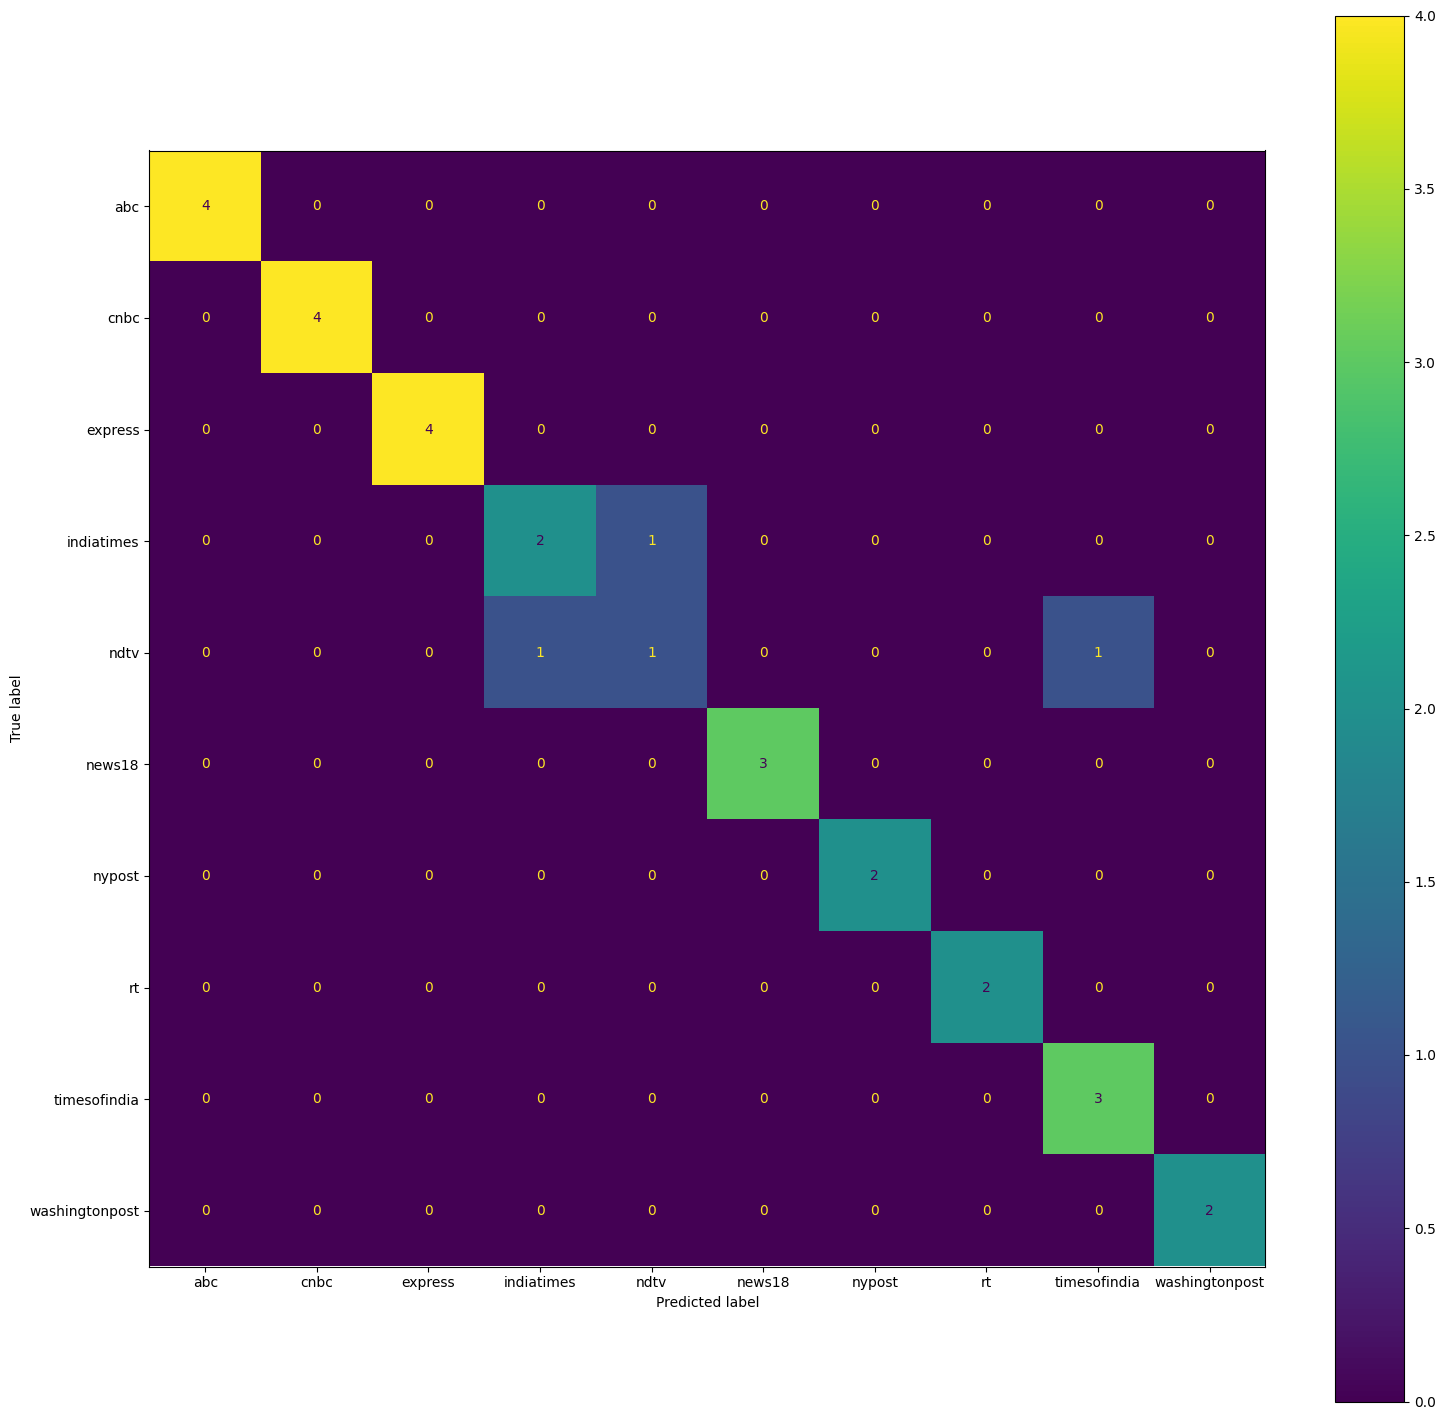

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18));
ConfusionMatrixDisplay.from_predictions(pridiction, y_test, ax=ax);

Text(0, 0.5, 'Error Rate')

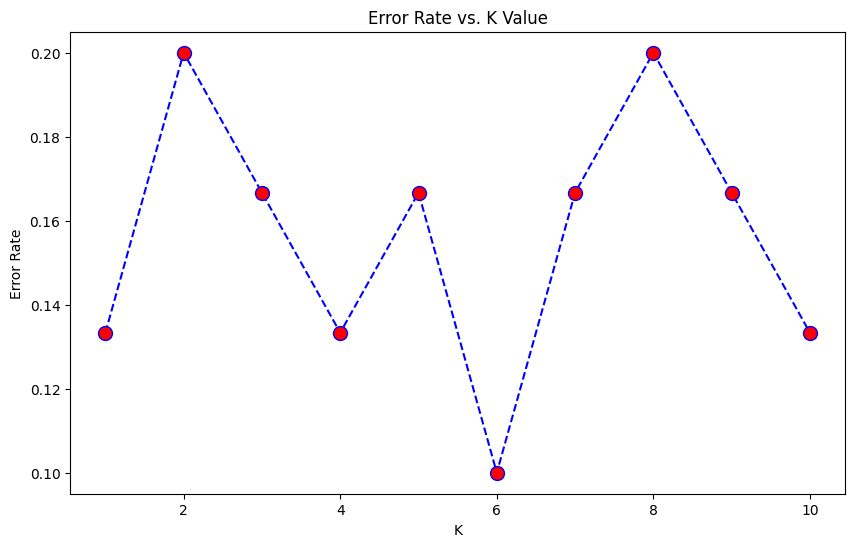

In [ ]:
error_rate = []
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pridict = knn.predict(X_test)
    error_rate.append(np.mean(pridict != y_test))
plt.figure(figsize=(10,6))
plt.plot(range(1,11),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Text(0, 0.5, 'Accuracy Rate')

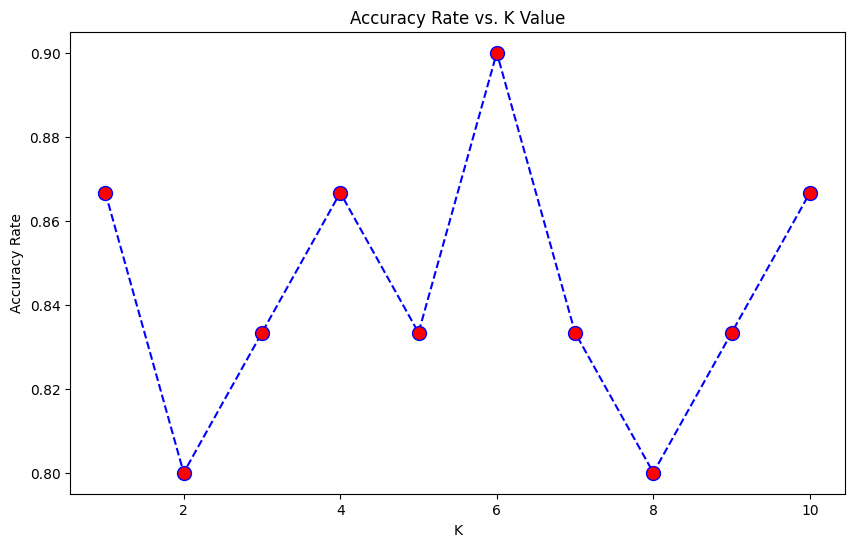

In [ ]:
accuracy_rate = []
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pridict = knn.predict(X_test)
    accuracy_rate.append(1-(np.mean(pridict != y_test)))
plt.figure(figsize=(10,6))
plt.plot(range(1,11),accuracy_rate,color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

**Saving data as zip file:**

In [ ]:
!zip -r captures.zip captures/

  adding: captures/ (stored 0%)
  adding: captures/https_captures_for_www.timesofindia.com_1.csv (deflated 84%)
  adding: captures/https_captures_for_www.nypost.com_1.csv (deflated 84%)
  adding: captures/https_captures_for_www.rt.com_1.csv (deflated 92%)
  adding: captures/https_captures_for_www.express.co.uk_3.csv (deflated 91%)
  adding: captures/https_captures_for_www.indiatimes.com_1.csv (deflated 85%)
  adding: captures/https_captures_for_www.nypost.com_3.csv (deflated 84%)
  adding: captures/https_captures_for_www.abc.net.au_2.csv (deflated 91%)
  adding: captures/https_captures_for_www.news18.com_1.csv (deflated 91%)
  adding: captures/https_captures_for_www.news18.com_3.csv (deflated 91%)
  adding: captures/https_captures_for_www.cnbc.com_1.csv (deflated 91%)
  adding: captures/https_captures_for_www.washingtonpost.com_2.csv (deflated 83%)
  adding: captures/https_captures_for_www.abc.net.au_1.csv (deflated 91%)
  adding: captures/https_captures_for_www.express.co.uk_2.csv (de

In [ ]:
final_df.to_csv('final_csv.csv')

**Saving trained model:**

In [ ]:
import pickle
# Its important to use binary mode
knnPickle = open('knn_model', 'wb')

# source, destination
pickle.dump(knn, knnPickle)

# close the file
knnPickle.close()


In [ ]:
#!rm -rf captures

**Getting next set of datas:**

In [ ]:
packet_capturing(3)

https://www.indiatimes.com <class 'str'>
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
32 packets captured
32 packets received by filter
0 packets dropped by kernel
Running as user "root" and group "root". This could be dangerous.
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
30 packets captured
30 packets received by filter
0 packets dropped by kernel
Running as user "root" and group "root". This could be dangerous.
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
30 packets captured
30 packets received by filter
0 packets dropped by kernel
Running as user "root" and group "root". This could be dangerous.
https://www.washingtonpost.com <class 'str'>
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
21 packets captured
21 packets received by filter
0 packets dropped by kernel
Running as user "root" and group "root". This could be dange

In [ ]:
dataset = data_frame_maker()

<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-input-15-6bf5b0d854de>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df)
<ipython-i

,site_name,direction,srcport,dport,number_of_packet,total_of_bytes,min_packet_size,max_packet_size,mean_packet_size,std_packet_size,duration,min_iat,max_iat,mean_iat,std_iat
0,express,uplink,50410,443,84,5206.0,52.0,569.0,61.976190,57.504736,0.209892,0.000007,0.057150,0.002529,0.007263
1,express,uplink,51692,443,84,5206.0,52.0,569.0,61.976190,57.504736,0.210437,0.000011,0.055660,0.002535,0.007233
2,express,uplink,53064,443,76,4790.0,52.0,569.0,63.026316,60.396904,0.657080,0.000008,0.281538,0.008761,0.034935
3,cnbc,uplink,37460,443,261,14398.0,40.0,569.0,55.164751,32.951358,0.579456,0.000005,0.065364,0.002229,0.007426
4,indiatimes,uplink,50356,443,16,1750.0,40.0,569.0,109.375000,128.062940,0.291338,0.000004,0.055001,0.019423,0.023011
5,nypost,uplink,35474,443,14,1424.0,40.0,557.0,101.714286,133.558071,0.119032,0.000015,0.054764,0.009156,0.015400
6,nypost,uplink,50380,443,13,1384.0,40.0,557.0,106.461538,137.776761,0.123401,0.000012,0.054751,0.010283,0.015948
7,nypost,uplink,55986,443,13,1384.0,40.0,557.0,106.461538,137.776761,0.125390,0.000017,0.058348,0.010449,0.016831
8,ndtv,uplink,33248,443,17,1711.0,40.0,569.0,100.647059,123.695665,0.124752,0.000006,0.054473,0.007797,0.014207
9,ndtv,uplink,49752,443,17,1699.0,40.0,569.0,99.941176,124.024428,0.150093,0.000012,0.081753,0.009381,0.020310


In [ ]:
final_df = final_df_maker(dataset)
final_df = pd.DataFrame(final_df)
final_df.head(5)

,site_name,number_of_packet_up,total_of_bytes_up,min_packet_size_up,max_packet_size_up,mean_packet_size_up,std_packet_size_up,duration_up,min_iat_up,max_iat_up,...,total_of_bytes_down,min_packet_size_down,max_packet_size_down,mean_packet_size_down,std_packet_size_down,duration_down,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,express,84,5206.0,52.0,569.0,61.976190,57.504736,0.209892,0.000007,0.057150,...,448978.0,52.0,12904.0,5409.373494,3340.386989,0.191650,0.000001,0.075643,0.002337,0.008807
1,express,84,5206.0,52.0,569.0,61.976190,57.504736,0.210437,0.000011,0.055660,...,448917.0,52.0,12904.0,5542.185185,3241.016465,0.191555,0.000001,0.074760,0.002394,0.008878
2,express,76,4790.0,52.0,569.0,63.026316,60.396904,0.657080,0.000008,0.281538,...,448960.0,52.0,15760.0,5830.649351,4609.650329,0.639105,0.000001,0.221882,0.008409,0.029677
3,cnbc,261,14398.0,40.0,569.0,55.164751,32.951358,0.579456,0.000005,0.065364,...,2095031.0,52.0,31908.0,8026.938697,7520.582433,0.536988,0.000001,0.098556,0.002065,0.008257
4,indiatimes,16,1750.0,40.0,569.0,109.375000,128.062940,0.291338,0.000004,0.055001,...,7219.0,52.0,2948.0,515.642857,833.287706,0.248517,0.000002,0.097282,0.019117,0.030514


In [ ]:
x = final_df.drop(['site_name'],axis=1)
y = final_df['site_name']

In [ ]:
X = pd.DataFrame()
for key in x:
  temp = x[key]
  temp_norm = (temp-temp.mean())/temp.std();
  X[key] = temp_norm

X.head()

,number_of_packet_up,total_of_bytes_up,min_packet_size_up,max_packet_size_up,mean_packet_size_up,std_packet_size_up,duration_up,min_iat_up,max_iat_up,mean_iat_up,...,total_of_bytes_down,min_packet_size_down,max_packet_size_down,mean_packet_size_down,std_packet_size_down,duration_down,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,0.233889,0.242437,2.198484,0.327731,-0.865251,-0.802752,-0.248536,-0.200678,-0.197391,-0.220753,...,0.098269,0.327731,0.115169,0.600725,0.105890,-0.245276,-0.192389,-0.196666,-0.222476,-0.204057
1,0.233889,0.242437,2.198484,0.327731,-0.865251,-0.802752,-0.248216,0.450170,-0.198271,-0.220703,...,0.098171,0.327731,0.115169,0.636671,0.080727,-0.245332,-0.192389,-0.197192,-0.222109,-0.203918
2,0.112125,0.121053,2.198484,0.327731,-0.821866,-0.734807,0.013670,-0.037966,-0.064919,-0.173521,...,0.098241,0.327731,0.308618,0.714744,0.427293,0.017801,-0.192389,-0.109634,-0.183499,-0.162934
3,2.927923,2.924556,-0.439697,0.327731,-1.146657,-1.379575,-0.031845,-0.526102,-0.192542,-0.223027,...,2.743018,0.327731,1.402392,1.309171,1.164401,-0.042238,-0.192389,-0.183030,-0.224222,-0.205142
4,-0.801107,-0.765983,-0.439697,0.327731,1.092972,0.854845,-0.200780,-0.688814,-0.198660,-0.092721,...,-0.611514,0.327731,-0.559194,-0.723767,-0.528958,-0.211842,-0.096194,-0.183788,-0.114766,-0.161285


**Load the model from disk:**

In [ ]:
import pickle
loaded_model = pickle.load(open('knn_model', 'rb'))
pridiction = loaded_model.predict(X)
print(classification_report(pridiction, y))

                precision    recall  f1-score   support

           abc       1.00      0.38      0.55         8
          cnbc       1.00      1.00      1.00         3
       express       1.00      1.00      1.00         3
    indiatimes       1.00      0.50      0.67         6
          ndtv       0.67      1.00      0.80         2
        news18       0.00      0.00      0.00         1
        nypost       1.00      1.00      1.00         3
            rt       0.00      0.00      0.00         1
  timesofindia       0.33      1.00      0.50         1
washingtonpost       0.67      1.00      0.80         2

      accuracy                           0.67        30
     macro avg       0.67      0.69      0.63        30
  weighted avg       0.87      0.67      0.70        30



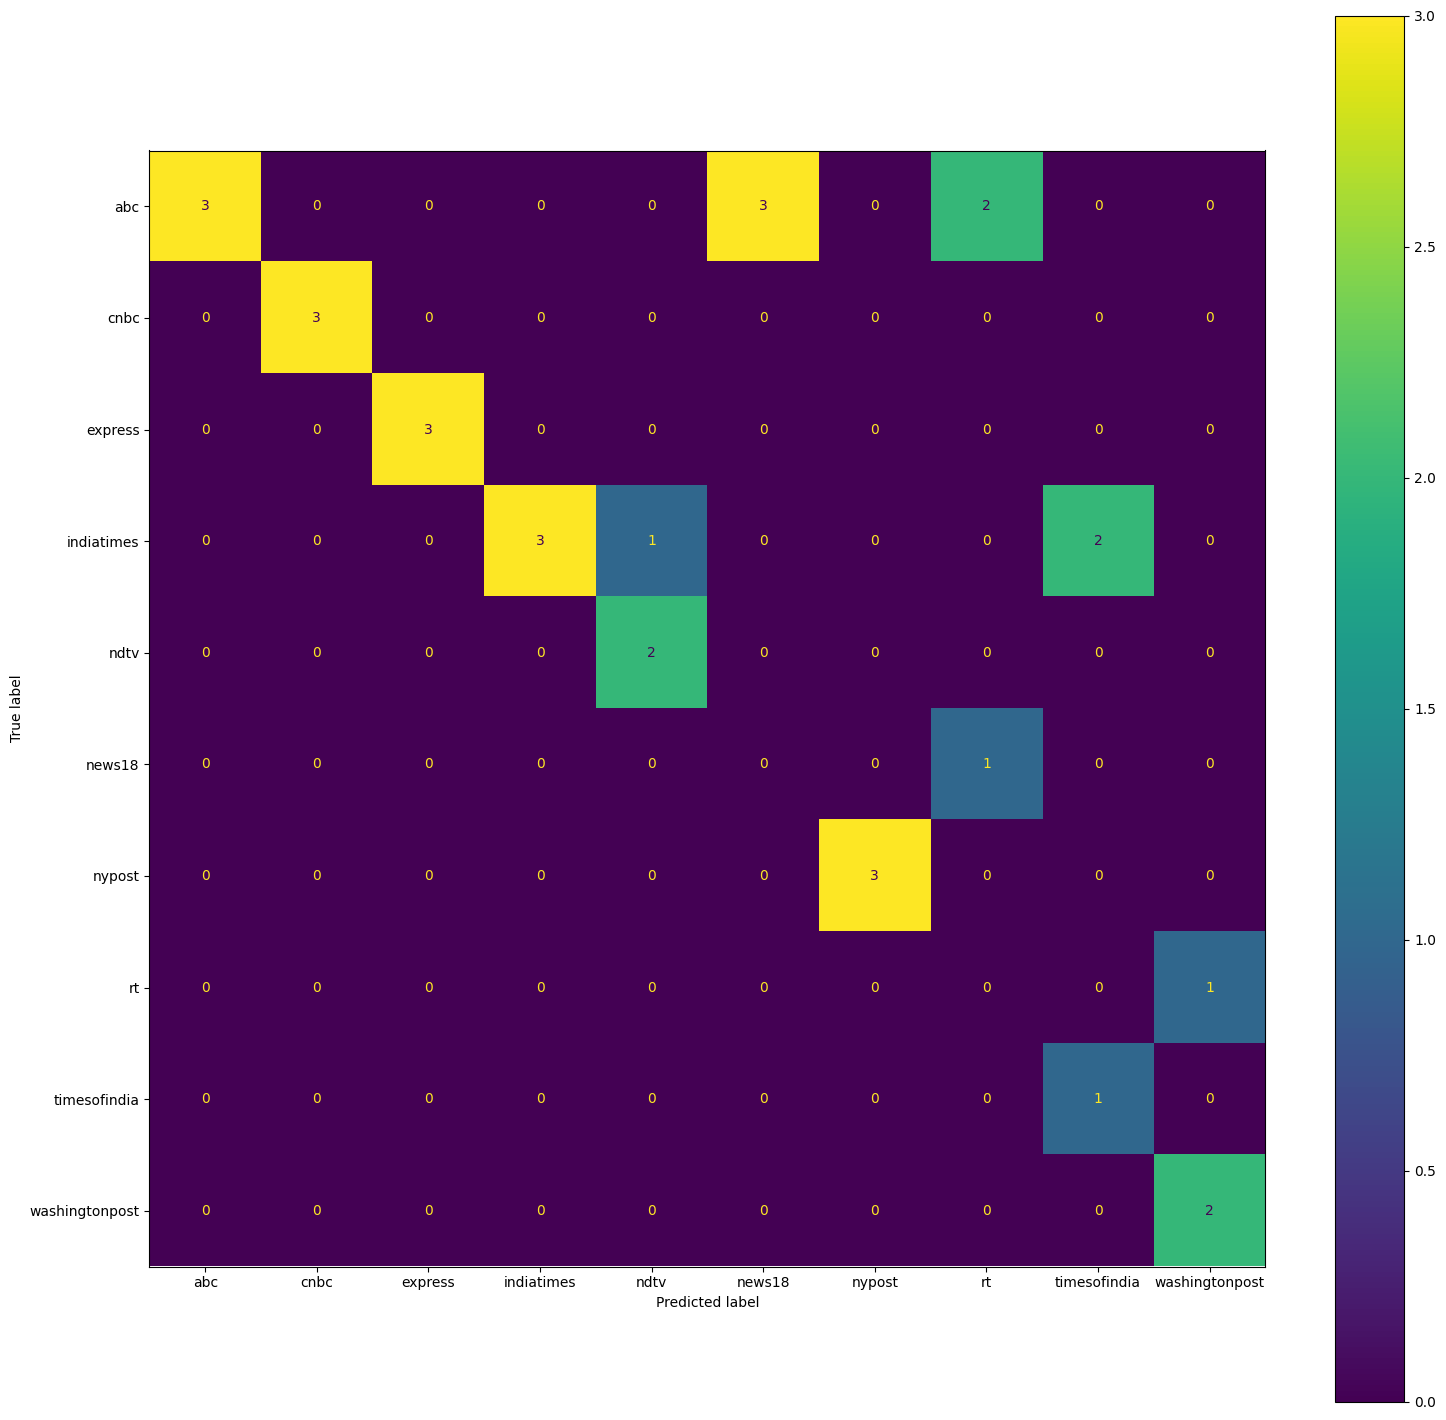

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18));
ConfusionMatrixDisplay.from_predictions(pridiction, y, ax=ax);

**Result:**<br>
As we can see, at the first we have accuracy of 90% but when we get the second accuracy it dropped to 67%. this is because we overfit our model for first data and due to that our model is not that accurate.<br>we have 2 options:

1.   We need to find a KNN value that works well in these two datas.
2.   Another solution is that we visit this sites more and grab more data so we can develop a better model
**In the end:**<br>Some sites like abc, cnbc works well even with second datas but some like new18 have an accuracy of 0 for second dataset